Acquisition code pulled from https://github.com/CIROH-UVM/training-data-workflows-101/blob/main/05-ExpandingTheWorkflow_Acquire.ipynb

In [1]:
from s3fs import S3FileSystem, S3Map
import xarray as xr
import pyproj
import geopandas as gpd
import os
import numpy as np

# def get_nwm_retrospective_LDAS(site_gdf, start=None, end=None, var=None):
#     '''
#     '''
#     bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
#     fs = S3FileSystem(anon=True)
#     ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')
    
#     if var is not None:
#         ds = ds[var]
      
#     # Extract data by each site location
#     ds_list = [np.squeeze(ds.sel(x=x, y=y, method='nearest')) for x, y in zip(site_gdf.geometry.x.values, site_gdf.geometry.y.values)]

#     if start is not None and end is not None:
#         ds_list = [ds.sel(time=slice(f'{start}T00:00:00', f'{end}T23:00:00')) for ds in ds_list]
    
#     return ds_list

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/nwm/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# For the NWM env follow these instructions
# https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
pyprojdatadir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-hb784bbd_0/share/proj'
pyproj.datadir.set_data_dir(pyprojdatadir)

In [3]:
# bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
# fs = S3FileSystem(anon=True)
# ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')

In [4]:
# var = 'SNOWH'
# print(ds[var])
# print(f'Variable size: {ds[var].nbytes/1e12:.1f} TB')

## Load SNOTEL site location data
Add in the snotel location code here so there's no need to read/write to file  
TODO: Need to keep site_name associated with extracted ds for plotting and in metadata of extracted DS

In [5]:
site_gdf = gpd.read_file('/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/yampa_sites.json')
site_gdf

ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 3 is expected. It comes from another PROJ installation.


,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
0,SNTL,CO,Bear River (1061),None,2004-October,40.06,-107.01,9112,Routt,Yamcolo Reservoir-Bear River (140500010102),1061,POINT (328571.15744 4436352.34706)
1,SNTL,CO,Buffalo Park (913),None,1995-September,40.23,-106.60,9249,Grand,Deer Creek-Red Dirt Creek (140100010706),913,POINT (363880.83767 4454513.15666)
2,SNTL,CO,Crosho (426),None,1985-October,40.17,-107.06,8973,Rio Blanco,Hunt Creek (140500010106),426,POINT (324589.43355 4448660.39629)
3,SNTL,CO,Dry Lake (457),None,1979-October,40.53,-106.78,8271,Routt,City of Steamboat Springs-Yampa River (1405000...,457,POINT (349237.12327 4488106.85307)
4,SNTL,CO,Elk River (467),None,1978-October,40.85,-106.97,8739,Routt,Steamboat Lake-Willow Creek (140500010206),467,POINT (333940.15398 4523973.53493)
5,SNTL,CO,Lost Dog (940),None,1998-August,40.82,-106.75,9327,Routt,Outlet North Fork Elk River (140500010203),940,POINT (352419.26997 4520249.18863)
6,SNTL,CO,Rabbit Ears (709),None,1985-October,40.37,-106.74,9411,Routt,Harrison Creek (140500010402),709,POINT (352275.16748 4470278.06683)
7,SNTL,CO,Ripple Creek (717),None,1985-October,40.11,-107.29,10350,Rio Blanco,Snell Creek-North Fork White River (140500050102),717,POINT (304831.3735 4442479.75675)
8,SNTL,CO,Tower (825),None,1978-October,40.54,-106.68,10620,Routt,Fish Creek (140500010407),825,POINT (357728.50153 4489050.68327)


In [6]:
# # Use WKT to get proj 4 string
# # https://gis.stackexchange.com/questions/8547/what-is-the-best-way-to-programmatically-convert-between-wkt-and-proj4-string

# from osgeo import osr
# srs = osr.SpatialReference()
# wkt_text = ds[var].attrs['esri_pe_string']
# print(wkt_text)

# srs.ImportFromWkt(wkt_text)
# srs.MorphFromESRI()
# print(f"WKT for use as .prj: {srs.ExportToWkt()}")
# print(f"Equivalent proj4 string: {srs.ExportToProj4()}")
# proj4 = srs.ExportToProj4()
# proj4

## Write this to file somehow

In [7]:
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"

In [8]:
# with open(proj_fn, "w") as text_file:
#     text_file.write(proj4)

In [9]:
with open(proj_fn, "r") as f:
    proj4 = f.read()
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [10]:
site_gdf.set_crs('epsg:32613', inplace=True, allow_override=True)
site_gdf = site_gdf.to_crs(crs=proj4)
site_gdf.crs

<Projected CRS: +proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [11]:
%%time
yampa_nwm_ds = get_nwm_retrospective_LDAS(site_gdf, start='2019-10-01', end='2020-09-30', var='SNOWH')

CPU times: user 1.2 s, sys: 151 ms, total: 1.35 s
Wall time: 7.54 s


In [12]:
import matplotlib.pyplot as plt

CPU times: user 2.7 s, sys: 1.88 s, total: 4.57 s
Wall time: 15.7 s


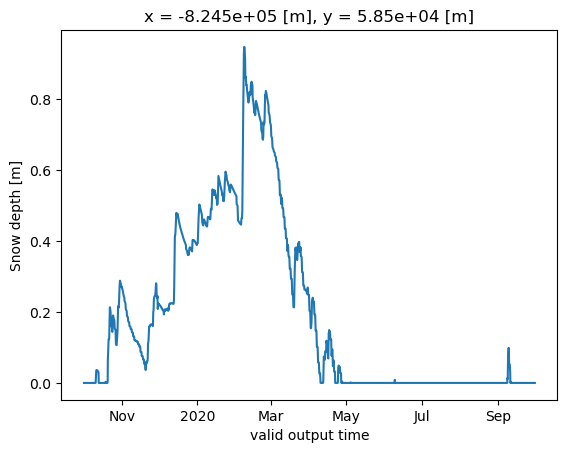

In [14]:
%%time
yampa_nwm_ds[0].plot()

CPU times: user 25.1 s, sys: 18.6 s, total: 43.7 s
Wall time: 2min 14s


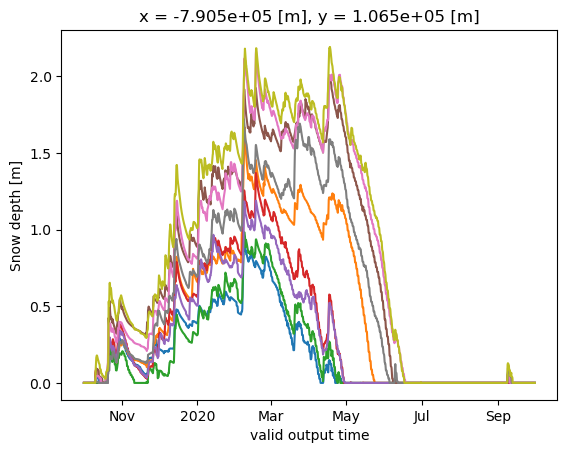

In [16]:
%%time
fig, ax = plt.subplots(1)
for ds in yampa_nwm_ds:
    ds.plot(ax=ax)